In [2]:
from loguru import logger
import scimap as sm
import pandas as pd
import anndata as ad
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

Running SCIMAP  2.1.3


In [73]:
import geopandas as gpd
import shapely
import time

In [64]:
#import csv
path_to_csv = "../data/quantification/993_backsub_quantification.csv"
adata = utils.read_quant( path_to_csv )

2024-09-16 11:33:19.251 | INFO     | utils:read_quant:18 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-16 11:33:20.858 | INFO     | utils:read_quant:37 -  304243 cells and 75 variables
2024-09-16 11:33:20.858 | INFO     | utils:read_quant:38 -  ---- read_quant is done, took 1s  ----


In [189]:
# load geojson file
path_to_geojson = "../data/geojsons/993.geojson"

In [197]:
def filter_by_annotation(adata, path_to_geojson):
    """ Filter cells by annotation in a geojson file """

    logger.info(" ---- filter_by_annotation : version number 1.0.0 ----")
    time_start = time.time()
    
    gdf = gpd.read_file(path_to_geojson)
    assert gdf.geometry is not None, "No geometry found in the geojson file"
    assert gdf.geometry.type.unique()[0] == 'Polygon', "Only polygon geometries are supported"

    adata.obs['point_geometry'] = adata.obs.apply(lambda cell: shapely.geometry.Point( cell['X_centroid'], cell['Y_centroid']), axis=1)
    
    def label_point_if_inside_polygon(point, polygons):
        for i, polygon in enumerate(polygons):
            if polygon.contains(point):
                return f"ann_{i+1}"
        return "Keep"

    adata.obs['filter_by_ann'] = adata.obs['point_geometry'].apply(lambda cell: label_point_if_inside_polygon(cell, gdf.geometry))

    #plotting
    labels_to_plot = list(adata.obs['filter_by_ann'].unique())
    labels_to_plot.remove("Keep")
    max_x, max_y = adata.obs[['X_centroid', 'Y_centroid']].max()

    tmp_df_ann = adata.obs[adata.obs['filter_by_ann'].isin(labels_to_plot)]
    tmp_df_Keep = adata.obs[adata.obs['filter_by_ann'] == 'Keep'].sample(frac=0.2, random_state=0).reset_index(drop=True)

    sns.scatterplot(data=tmp_df_Keep, x='X_centroid', y='Y_centroid', hue='filter_by_ann', palette='grey', linewidth=0, s=3, alpha=0.1)
    sns.scatterplot(data=tmp_df_ann, x='X_centroid', y='Y_centroid', hue='filter_by_ann', palette='bright', linewidth=0, s=8)

    plt.xlim(0, max_x)
    plt.ylim(max_y, 0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=3)

    # Show value counts
    value_counts = tmp_df_ann['filter_by_ann'].value_counts()
    value_counts_str = "\n".join([f"{cat}: {count}" for cat, count in value_counts.items()])

    plt.gca().text(1.05, 0.5, f"Cells Counts:\n{value_counts_str}",
            transform=plt.gca().transAxes, 
            fontsize=12, 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

    logger.info(f" ---- filter_by_annotation is done, took {int(time.time() - time_start)}s  ----")
    return adata

2024-09-16 13:27:14.261 | INFO     | __main__:filter_by_annotation:4 -  ---- filter_by_annotation : version number 1.0.0 ----


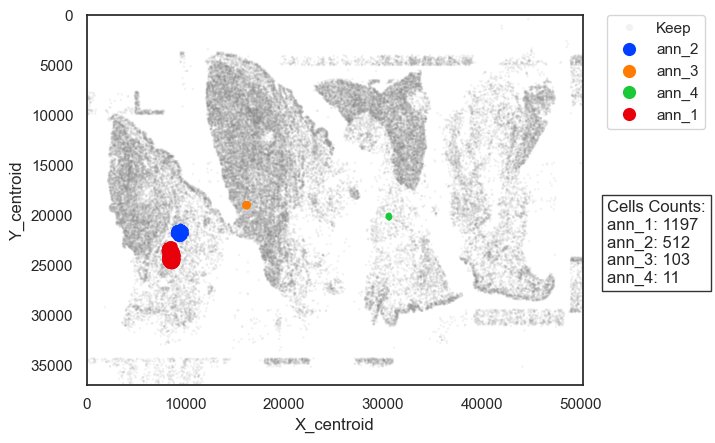

2024-09-16 13:27:25.632 | INFO     | __main__:filter_by_annotation:48 -  ---- filter_by_annotation is done, took 11s  ----


In [198]:
adata = filter_by_annotation(adata, path_to_geojson)